In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
colors = sns.color_palette("hls")

import random
import datetime
import numpy as np
import gc
import os

import scipy.sparse as sp
import pandas as pd
from tqdm.auto import tqdm

from itertools import islice, cycle
from more_itertools import pairwise
from implicit.nearest_neighbours import TFIDFRecommender
from scipy.sparse.linalg import svds

plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

import seaborn as sns
sns.set(style = 'whitegrid')
sns.set(rc = {'figure.figsize':(17, 9)})

from IPython import display
display.display(display.HTML('<style>.container { width:80% !important; }</style>'))
display.display(display.HTML('<style>.prompt { min-width:10ex !important; }</style>'))
display.display(display.HTML('<style>div#notebook { font-size:12px !important; }</style>'))

import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.simplefilter(action = 'ignore', category = DeprecationWarning)
warnings.simplefilter(action = 'ignore', category = UserWarning)
warnings.simplefilter(action = 'ignore', category = RuntimeWarning)
warnings.filterwarnings("ignore", message = "numpy.dtype size changed")
warnings.filterwarnings("ignore", message = "numpy.ufunc size changed")
pd.options.mode.chained_assignment = None
pd.set_option('mode.chained_assignment', None)


path = '../input/'

user_id = 'user_id'
item_id = 'item_id'
rank = 'emoji'
date = 'date'
top_N = 10

In [2]:
data = pd.read_parquet(path + "player_starts_train.parquet")
data.head(3)

,date,user_id,item_id,watch_time,is_autorized
0,2023-07-21 19:04:50+03:00,user_12964323,video_1042531,51,0
1,2023-07-21 02:02:41+03:00,user_16517,video_1707159,31,0
2,2023-07-21 22:00:47+03:00,user_15057892,video_1989987,9,0


In [3]:
videos = pd.read_parquet(path + "videos.parquet")
videos.head(3)

,item_id,video_title,author_title,tv_title,season,video_description,category_title,publicated,duration,channel_sub,tv_sub,ctr.CTR_10days_21_07,ctr.CTR_10days_01_08,ctr.CTR_10days_10_08,ctr.CTR_10days_21_08
0,video_165654,MSI Pro MP241X недоОБЗОР (РЕШЕНИЕ ПРОБЛЕМЫ С М...,Silvi,None,0,В видео я обывательским взглядом расскажу про ...,Технологии и интернет,2022-12-08 13:53:05+03:00,391382,0,0,NaN,0.0,0.0,NaN
1,video_1173704,Наложение пястно фаланговой повязки на кисть,"УЦ ""Академия Безопасности""",None,0,Видео с канала УЦ Академия безопасности (ab-dp...,Образование,2022-03-24 09:19:15+03:00,125922,26,0,NaN,0.0,0.0,0.0
2,video_23927,SilverstoneF1 Sochi Pro и Neoline x cop 6000s ...,Artur48,None,0,SilverstoneF1 Sochi Pro и Neoline x cop 6000s ...,Авто-мото,2022-03-19 17:41:49+03:00,436570,2,0,NaN,NaN,0.0,0.0


In [4]:
emotions = pd.read_csv(path + 'emotions.csv')
emotions.head(3)

,date,user_id,item_id,type,emoji
0,2023-08-03 21:37:22+03:00,user_21883648,video_2247834,v_top,v_top
1,2023-08-03 21:04:54+03:00,user_24016046,video_2247834,v_top,v_top
2,2023-08-03 20:37:06+03:00,user_20748867,video_22669,v_top,v_top


In [5]:
submission = pd.read_csv(path + "sample_submission.csv")
submission.head(3)

,user_id,recs
0,user_26511551,"['video_0', 'video_0', 'video_0', 'video_0', '..."
1,user_29194819,"['video_0', 'video_0', 'video_0', 'video_0', '..."
2,user_29734049,"['video_0', 'video_0', 'video_0', 'video_0', '..."


In [6]:
user_ids = data[user_id].unique()
print(len(user_ids))

28800762


In [8]:
data.head()

,date,user_id,item_id,watch_time,is_autorized,video_title,author_title,tv_title,season,video_description,category_title,publicated,duration,channel_sub,tv_sub,ctr.CTR_10days_21_07,ctr.CTR_10days_01_08,ctr.CTR_10days_10_08,ctr.CTR_10days_21_08
0,2023-07-21 19:04:50+03:00,user_12964323,video_1042531,51,0,"ШОК! ТОП 10 ФЕЙЛОВ, КОТОРЫЕ ВАС ТОЧНО УДИВЯТ!",TheSprint,None,0,"В этом видео-ролике Вы увидите ТОП 10 ФЕЙЛОВ, ...",Развлечения,2023-07-16 16:36:40+03:00,213718,3171,0,0.000000,0.000000,0.000000,0.000000
1,2023-07-21 02:02:41+03:00,user_16517,video_1707159,31,0,песня-В ЛУННОМ СИЯНИИ,Владимир Куперман гармонист,None,0,Замечатльный рроманс в Лунном сиянии,Музыка,2021-11-16 21:44:31+03:00,129562,22,0,0.000000,0.000000,0.000000,0.000000
2,2023-07-21 22:00:47+03:00,user_15057892,video_1989987,9,0,Юлия Пересильд о дружбе с мужчинами,Вокруг•ТВ,None,0,20 апреля в российских кинотеатрах вышел «Вызо...,Лайфстайл,2023-06-16 18:16:12+03:00,242006,2146,0,0.000000,NaN,0.000000,NaN
3,2023-07-21 19:09:43+03:00,user_2846972,video_1356486,-1,0,"Жить жизнь (2023) 1,2,3,4,5,6,7,8 серия",МУЛЬТИПЛЕКС,None,0,30-летняя Аня — образованная и яркая девушка. ...,Сериалы,2022-12-29 07:01:26+03:00,72000,6372,0,0.012027,0.013761,0.051701,0.041667
4,2023-07-21 11:06:58+03:00,user_20517034,video_1380654,11,0,a9qBMVK_460sv(1),rutube_account_23615734,None,0,None,Разное,2023-07-19 23:51:40+03:00,15134,421,0,0.027778,0.333333,NaN,NaN


In [9]:
def reduce_mem_usage(df, verbose = True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

reduce_mem_usage(data);
reduce_mem_usage(emotions);

Mem. usage decreased to 7405.22 Mb (30.6% reduction)
Mem. usage decreased to 14.09 Mb (0.0% reduction)


# Популярность видео и распределение взаимодействий

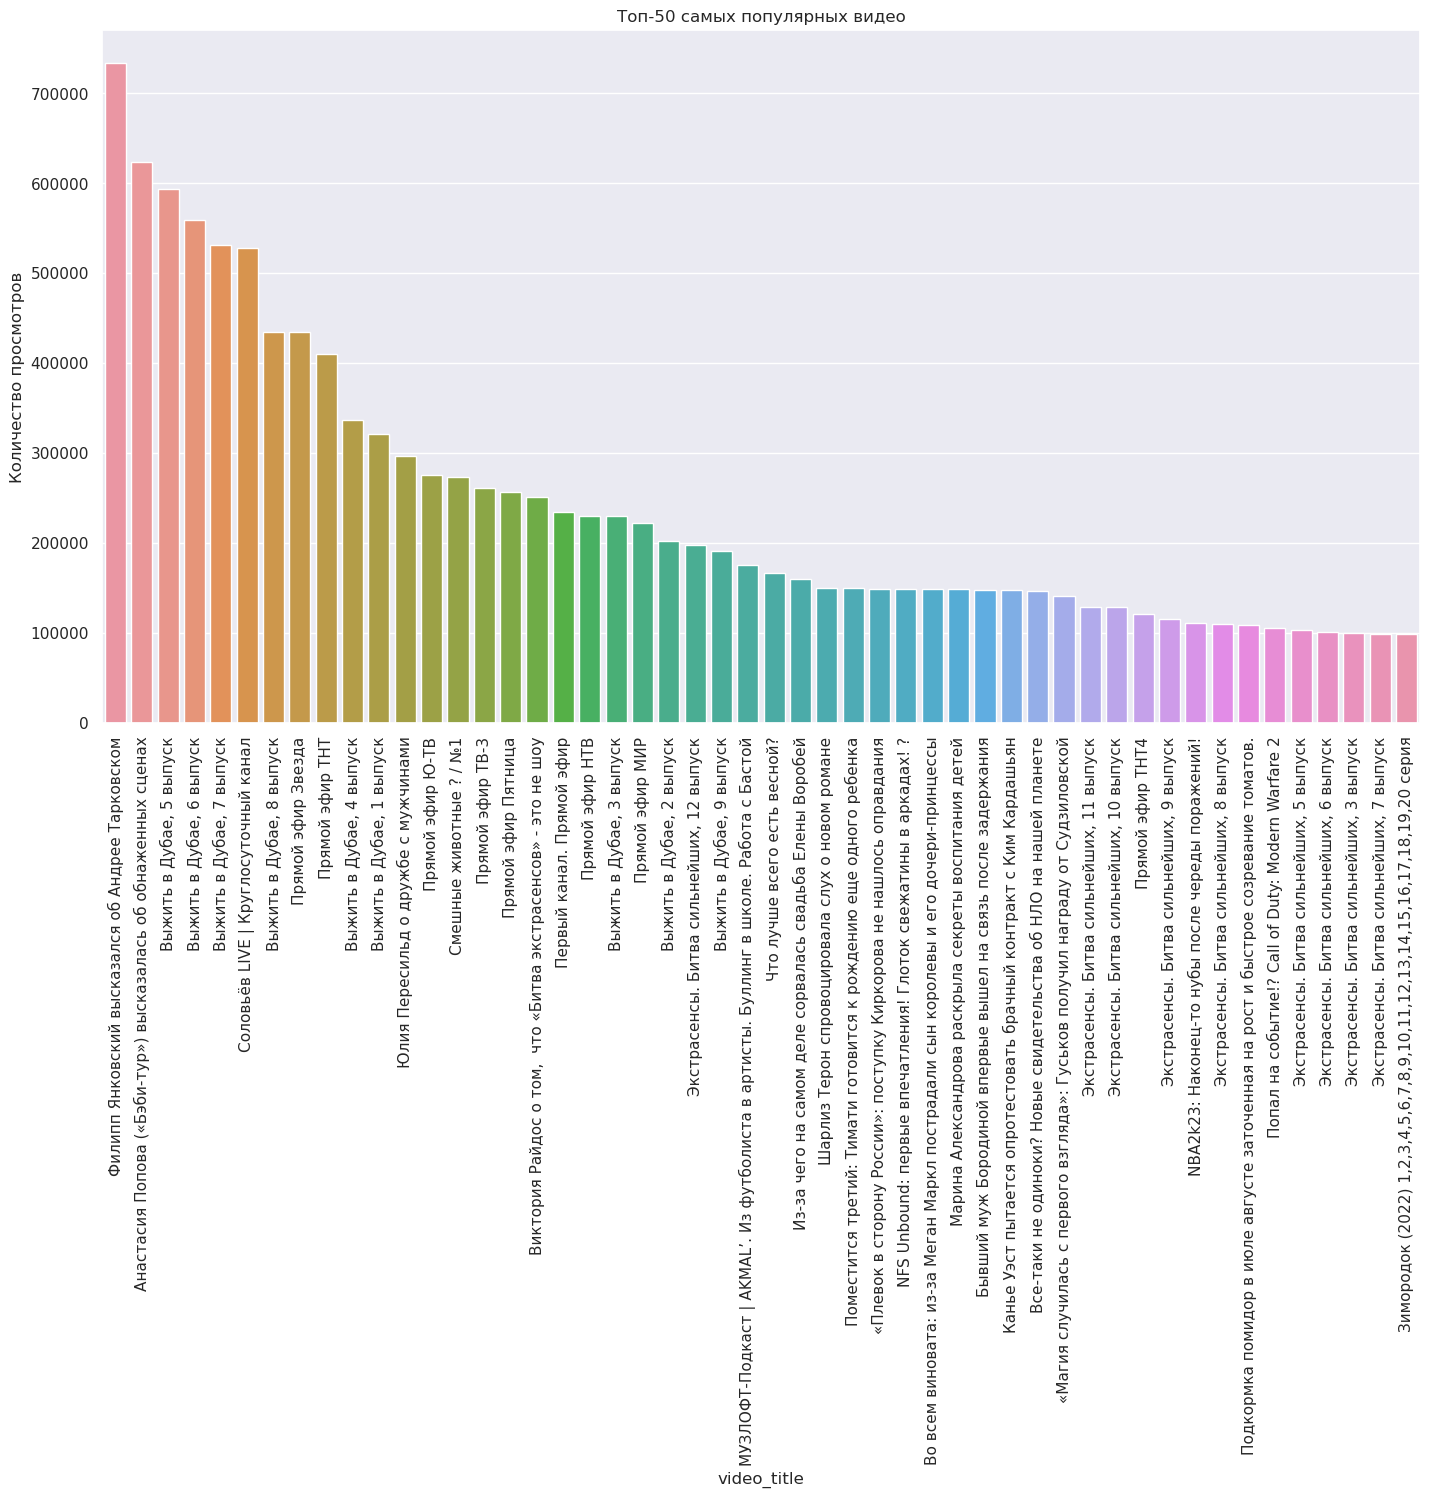

In [10]:
items_watch_count = data['video_title'].value_counts()
items_watch_cnt_df = pd.DataFrame(items_watch_count).rename(columns = {'video_title': 'item_watch_cnt'})
items_watch_cnt_df.reset_index(inplace = True)

bplot = sns.barplot(
    data = items_watch_cnt_df.head(50), 
    x = 'index', 
    y = 'item_watch_cnt', 
    order = items_watch_cnt_df.head(50)['index']
)

bplot.set_title('Топ-50 самых популярных видео')
bplot.set_ylabel('Количество просмотров')
bplot.set_xlabel('video_title')
bplot.set_xticklabels(items_watch_cnt_df.head(50)['index'], rotation = 90);

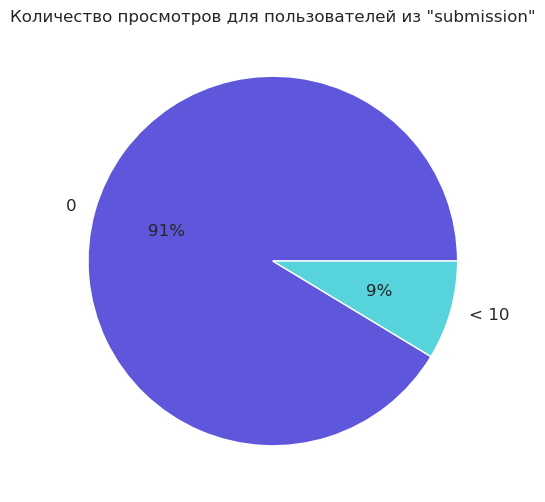

In [11]:
plt.figure(figsize = (6, 6))
user_watch_cnt = data.groupby(by = user_id)[item_id].count()

submission_stats = submission.join(user_watch_cnt, on = [user_id], how = 'left', rsuffix = 1).fillna(0)[[user_id, item_id]]

submission_stats.rename(columns = {item_id: 'num_watches'}, inplace = True)
submission_stats['user_cnt_category'] = pd.cut(
    submission_stats['num_watches'], 
    [0, 10, 15], 
    include_lowest = True, 
    right = False,
    labels = ['0', '< 10']
)

submission_stats['user_cnt_category'].value_counts(sort = False).plot(
    kind = 'pie', 
    colors = colors[-2:-7:-1], 
    ylabel = "",
    title = 'Количество просмотров для пользователей из "submission"',
    autopct = '%.0f%%',
    textprops = {'fontsize': 12}
);

In [12]:
print('Признаки и количество уникальных значений:\n')
data.nunique()

Признаки и количество уникальных значений:



date                     2764498
user_id                 28800762
item_id                  2320659
watch_time                 33913
is_autorized                   2
video_title              2229714
author_title              181628
tv_title                    3693
season                       202
video_description        1520291
category_title                46
publicated               2065058
duration                  611393
channel_sub                 2652
tv_sub                       159
ctr.CTR_10days_21_07        5871
ctr.CTR_10days_01_08        5764
ctr.CTR_10days_10_08        5888
ctr.CTR_10days_21_08        5900
dtype: int64

# Самое просматриваемое

In [13]:
data.video_title.value_counts()[:25]

Филипп Янковский высказался об Андрее Тарковском                                       733574
Анастасия Попова («Бэби-тур») высказалась об обнаженных сценах                         623398
Выжить в Дубае, 5 выпуск                                                               593420
Выжить в Дубае, 6 выпуск                                                               558543
Выжить в Дубае, 7 выпуск                                                               530582
Соловьёв LIVE | Круглосуточный канал                                                   528134
Выжить в Дубае, 8 выпуск                                                               433814
Прямой эфир Звезда                                                                     433751
Прямой эфир ТНТ                                                                        409793
Выжить в Дубае, 4 выпуск                                                               336190
Выжить в Дубае, 1 выпуск                                    

# Самые популярные авторы

In [14]:
data.author_title.value_counts()[:25]

Телеканал ТНТ                      7994890
Первый канал                       2414894
Вокруг•ТВ                          2185625
Тыгыдык!                           1929674
НТВ                                1578711
7Дней                              1485790
Гедонист                           1234304
ГПМ РТВ                             799186
На игре!                            783941
rutube_account_23615734             681226
Пятница                             676173
GameZ                               674634
Дом-2                               661123
МАТЧ!                               635862
РЕН ТВ                              574961
Соловьёв LIVE                       528556
AnimeMusic                          479360
ТЕЛЕКАНАЛ ЗВЕЗДА                    466480
COTOVASIA                           449215
Секретный Канал                     393775
РуАниме                             378986
Забавный попугай корелла Кеша       378522
Рецепты от Дарики                   366935
Экстрасенсы

# Самые популярные описания видео

In [15]:
data.video_description.value_counts()[:25]

Премьера! «Выжить в Дубае» – новое масштабное реалити канала ТНТ. Ради победы и приза в 10 миллионов рублей двум командам – звёздной и народной, –  придется пройти все испытания, которые только может готовить пустыня. Ведущие проекта –  любимая пара страны Павел Воля и Ляйсан Утяшева.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

# Самые популярные слова в описании категорий видео

In [16]:
%%time

from joblib import Parallel, delayed
import multiprocessing

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer
import re

N_JOBS = int(multiprocessing.cpu_count() / 1.5)

stop_words = stopwords.words('russian')
table = str.maketrans('', '', string.punctuation)
porter = PorterStemmer()

emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" #emotions
                           u"\U0001F300-\U0001F5FF" #sumbols and pictographs
                           u"\U0001F680-\U0001F6FF" #transport and map symbols
                           u"\U0001F1E0-\U0001F1FF" #flags
                           u"\U00002702-\U000027B0"  
                           u"\U000024C2-\U0001F251" 

                           "]+", flags = re.UNICODE)

def clean_text(text):
    
    #text = mystem.lemmatize(text.lower())
    #text = ' '.join(text)
    
    text = str(text)
    text = text.lower()
    #text = re.sub("[!@#$_“”¨«»®´·º½¾¿¡§£₤‘’]',", ' ', text)
    text = ' '.join(text.split())
    text = text.replace('\n', ' ') 
    text = text.replace('\r', ' ')
    text = text.replace('[', ' ')
    text = text.replace(']', ' ')
    text = text.replace("]'", " ")
    text = text.replace("',", " ")
    text = text.replace("['", " ")
    
    """
    # 3. Remove http, https
    text = re.sub(r'http\S+|https\S+', ' ', text)
    # 4. Remove email
    text = re.sub(r'\S+@\S+', ' ', text)
    # 5. Remove twitter id
    text = re.sub(r'@\w+', ' ', text)
    # 6. Remove "&lt;/b&gt;"
    text = re.sub(r'&lt;/b&gt;', ' ', text)
    # 7. Remove &quot; and quot;
    text = re.sub(r'&quot;|quot;', ' ', text)
    # 8. Replace &amp; and amp; with &
    text = re.sub(r'&amp;|amp;', '&', text)
    # 9. Replace &lt; and lt; with <
    text = re.sub(r'&lt;|lt;', '<', text)
    # 10. Replace &gt; and gt; with >
    text = re.sub(r'&gt;|gt;', '>', text)
    # 11. Remove the text inside parentheses
    text = re.sub(r'\(.*?\)', ' ', text)
    # 12. Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    """
    ###
    #tokens = word_tokenize(text)
    #tokens = [w.lower() for w in tokens]
    #stripped = [w.translate(table) for w in tokens]
    #words = [word for word in stripped if word.isalpha()]
    #words = [w for w in words if not w in stop_words]
    #stemmed = [porter.stem(word) for word in words]
    #text = ' '.join(stemmed)
    #text = emoji_pattern.sub(' ', text)
    ###
    
    return text

def clean_text2(df):
    df['category_title'] = df['category_title'].apply(lambda x: clean_text(x))
    return df

def clean_text_parallel(data, n_jobs = N_JOBS):
    n_batches = n_jobs
    batches = [data.iloc[i::n_batches] for i in range(n_batches)]
    
    data_out = Parallel(n_jobs = n_jobs)(
        delayed(clean_text2)(batch)
        for batch in batches
    )    
    data_out = pd.concat(data_out, axis = 0, ignore_index = False)
    return data_out

df2 = data[['category_title']].copy()
df2 = clean_text_parallel(df2)
df2.sort_index(inplace = True)

CPU times: user 26.4 s, sys: 30.8 s, total: 57.2 s
Wall time: 2min 10s


In [17]:
from collections import Counter

texts = ' '.join(list(df2['category_title'].values))

c = Counter(texts.split(' '))

In [18]:
df_count = pd.DataFrame.from_dict(c, orient = 'index').reset_index()
df_count.columns = ['word', 'count']
df_count.sort_values(by = ['count'], ascending=False, inplace = True)
df_count.reset_index(drop = True, inplace = True)
df_count.head(3)

,word,count
0,телепередачи,17550867
1,видеоигры,5667104
2,сериалы,5375151


Самые популярные слова в описании видео


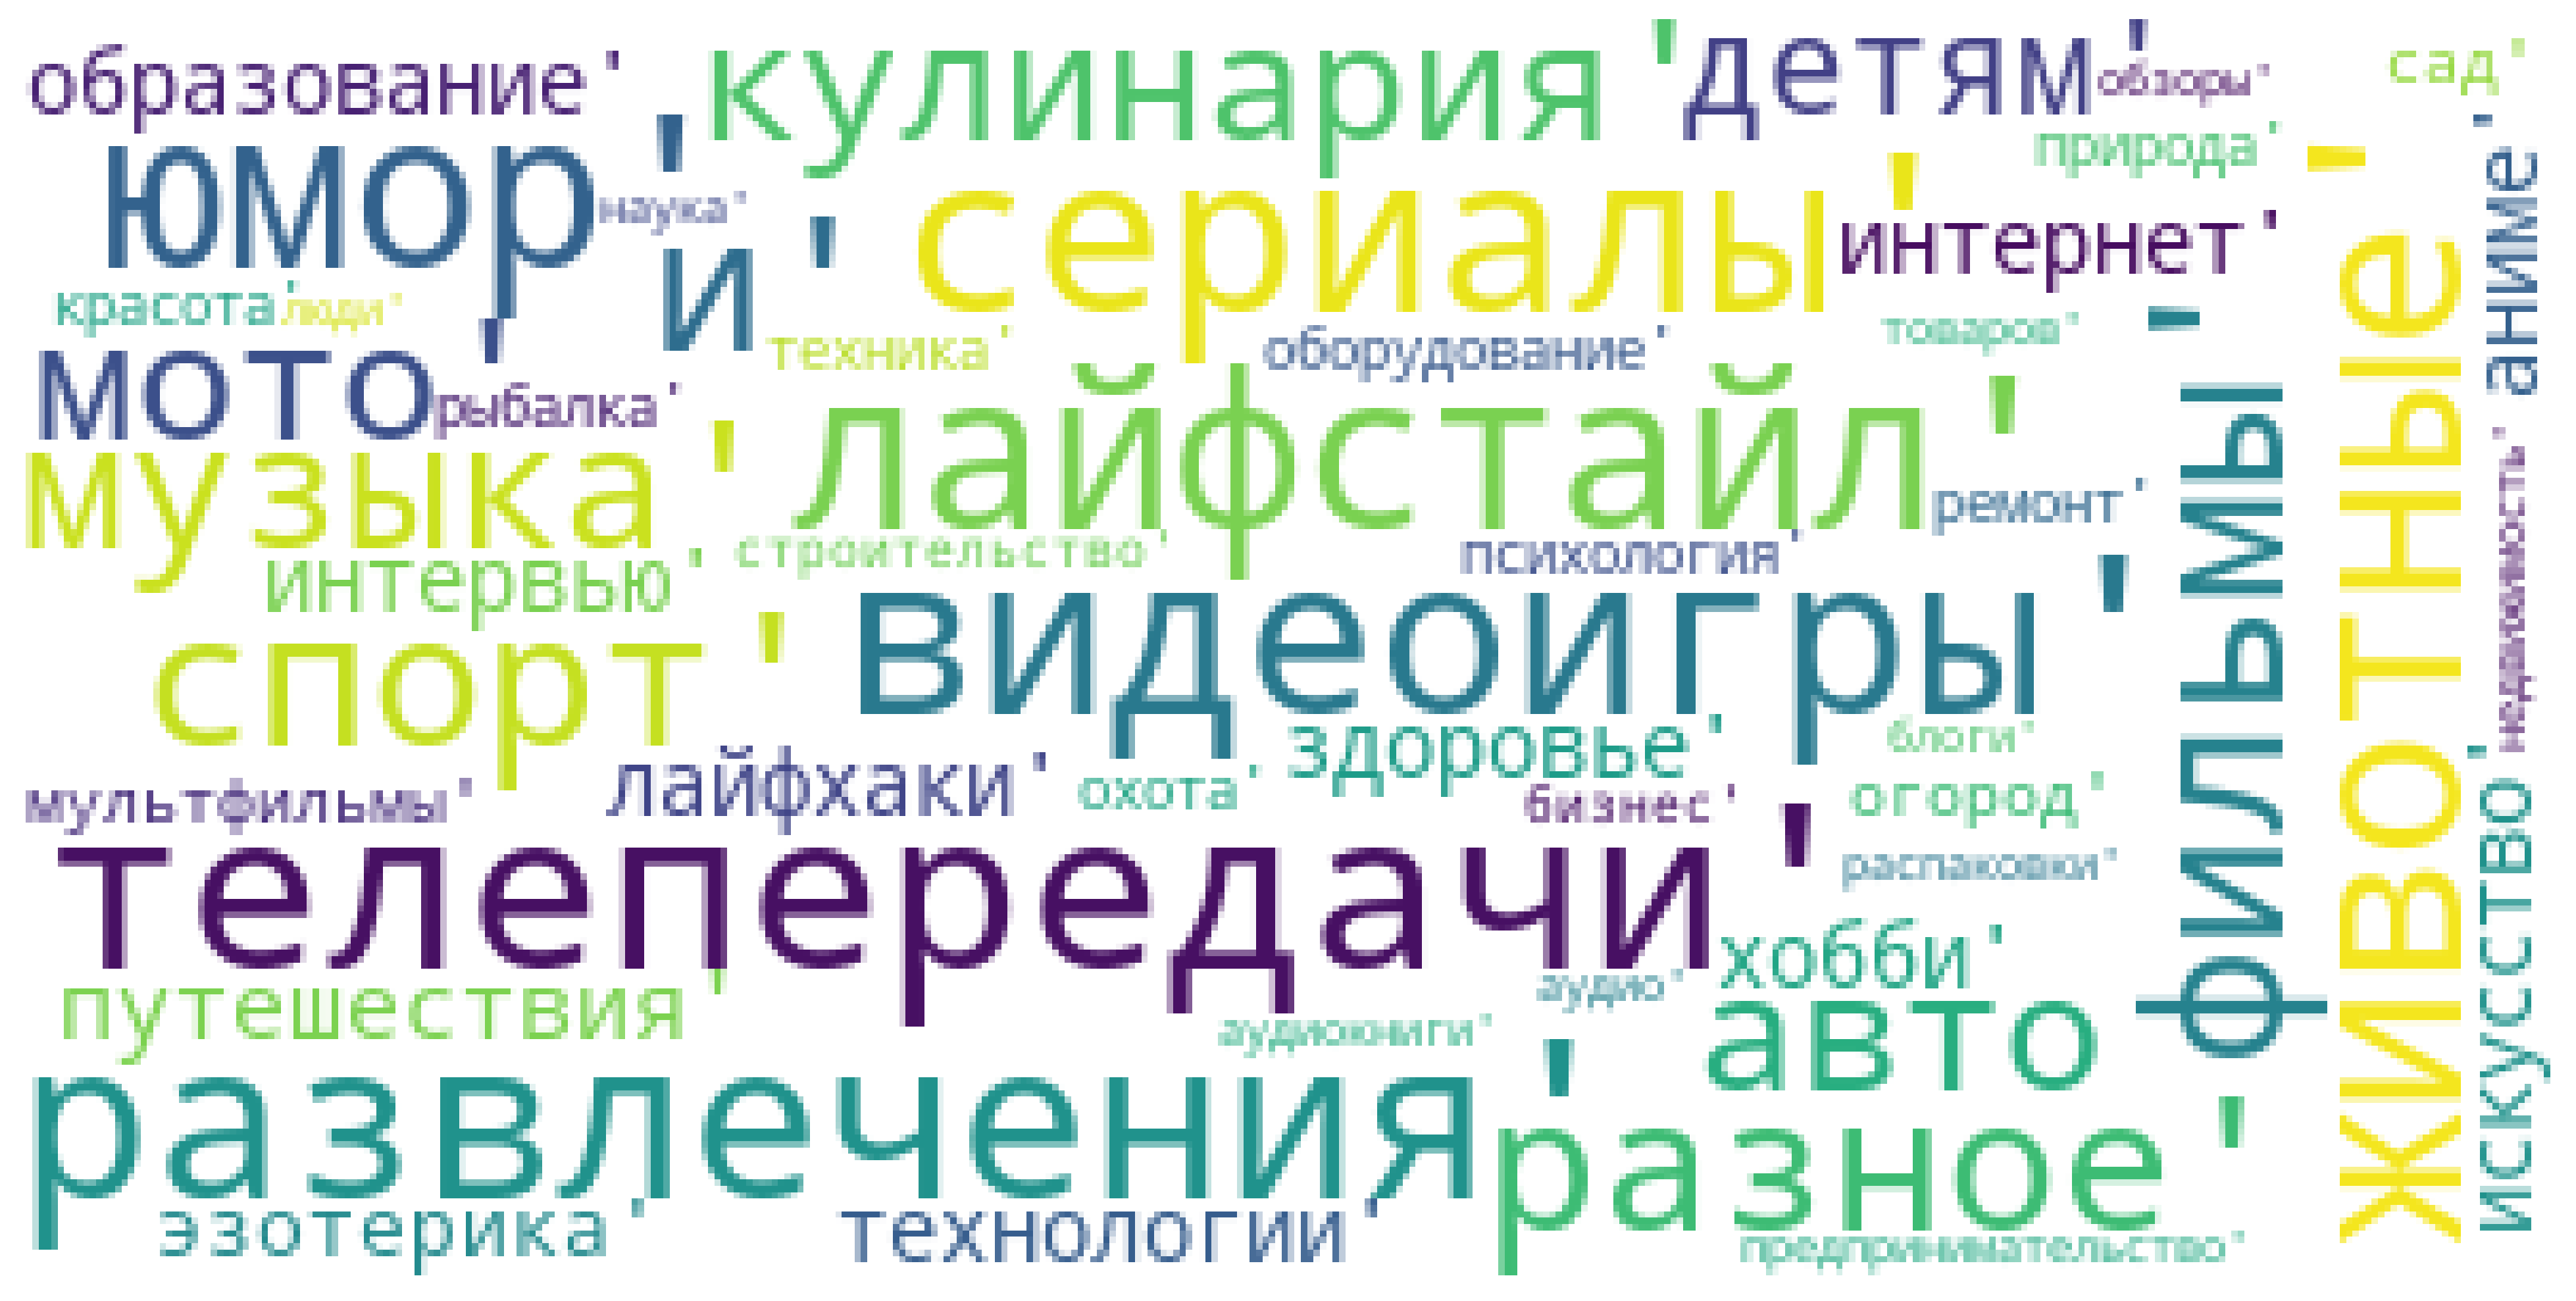

In [19]:
from wordcloud import WordCloud
from PIL import Image

plt.rcParams['font.size'] = 12                #10 
plt.rcParams['savefig.dpi'] = 200             #72 
plt.rcParams['figure.subplot.bottom']=.1 

#загружаем изображение и преобразуем в матрицу
#cake_mask = np.array(Image.open('../input/rutube.png'))

wordcloud = WordCloud(
    background_color = 'white',
    #mask = cake_mask,
    max_words = 50,
    max_font_size = 36, 
    #contour_color = '#0048BA',
    contour_width = 1,
    random_state = 0
).generate(str(df_count['word'].values[:50]))

print("Самые популярные слова в описании видео")

#ig = plt.figure(1)
plt.figure(figsize=(25, 15), dpi=200)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()